In [2]:
import geopandas as gpd
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt
import rasterio as ras
import numpy as np
import gc

In [3]:
elev = gpd.read_file("elev.geojson")
counties = gpd.read_file("orCounties.geojson")
known_time = gpd.read_file("landslidesKnownTime.geojson").to_crs("EPSG:4326")

In [4]:
known_time["YEAR"].max()

np.float64(2023.0)

<Axes: >

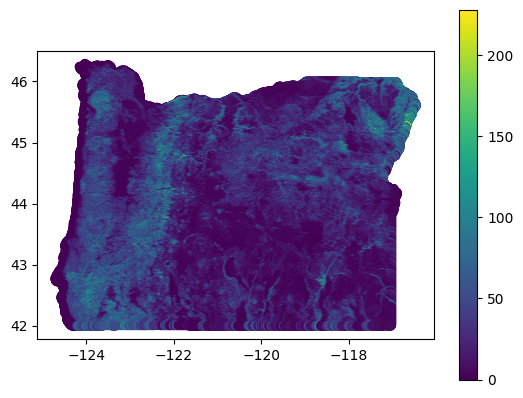

In [5]:
elev.plot(column="elev_std", legend=True)

In [20]:
center1 = elev.geometry.union_all().centroid

<Axes: >

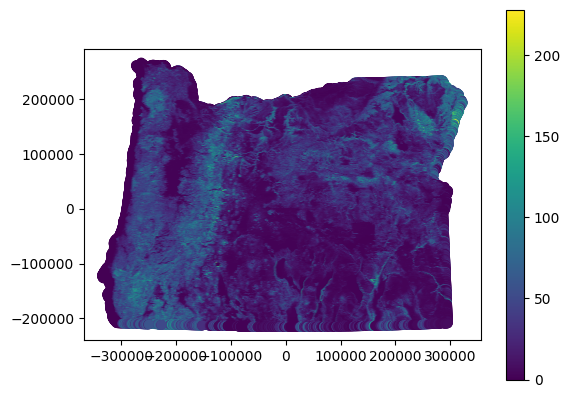

In [21]:
elev.to_crs(f"+proj=aeqd +lat_0={center1.y} +lon_0={center1.x}").plot(column="elev_std", legend=True)

In [33]:
counties.distance(counties.iloc[::-1].reset_index(drop=True))

C:\Users\1king\AppData\Local\Temp\ipykernel_7536\736460164.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties.distance(counties.iloc[::-1].reset_index(drop=True))


0     2.988911
1     2.963803
2     3.705655
3     6.276345
4     2.067935
5     1.953463
6     2.285198
7     3.875773
8     1.029916
9     0.789382
10    3.784515
11    0.924165
12    1.307423
13    0.126427
14    1.127515
15    2.061627
16    5.077724
17    2.543021
18    2.543021
19    5.077724
20    2.061627
21    1.127515
22    0.126427
23    1.307423
24    0.924165
25    3.784515
26    0.789382
27    1.029916
28    3.875773
29    2.285198
30    1.953463
31    2.067935
32    6.276345
33    3.705655
34    2.963803
35    2.988911
dtype: float64

In [36]:
332205.736181 / 2.988911

111146.07834793342

In [37]:
322010.272499 / 2.963803

108647.6639975734

In [40]:
counties.to_crs(epsg=2991).distance(counties.to_crs(epsg=2991).iloc[::-1].reset_index(drop=True))

0     332079.619712
1     321877.221507
2     334543.458750
3     529736.368713
4     196380.717301
5     189067.063809
6     222305.686354
7     324381.748436
8     114261.284856
9      82616.092160
10    313512.424163
11     92941.265381
12    105724.996488
13     14047.020871
14     95615.290293
15    162839.573027
16    402471.634774
17    200517.350574
18    200517.350574
19    402471.634774
20    162839.573027
21     95615.290293
22     14047.020871
23    105724.996488
24     92941.265381
25    313512.424163
26     82616.092160
27    114261.284856
28    324381.748436
29    222305.686354
30    189067.063809
31    196380.717301
32    529736.368713
33    334543.458750
34    321877.221507
35    332079.619712
dtype: float64

<Axes: >

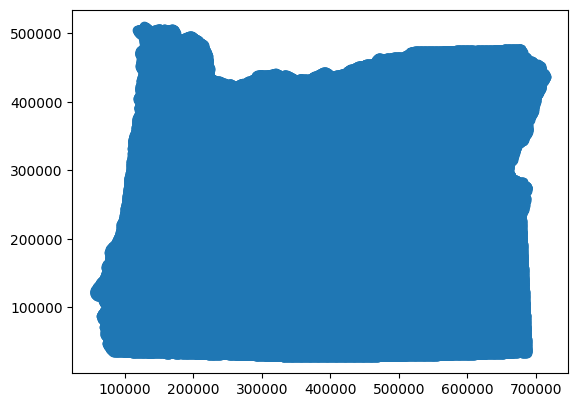

In [47]:
elev.to_crs(epsg=2991).plot()

<Axes: >

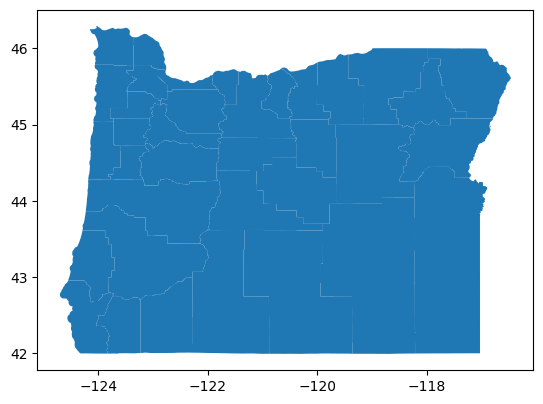

In [ ]:
counties.plot()

<Axes: >

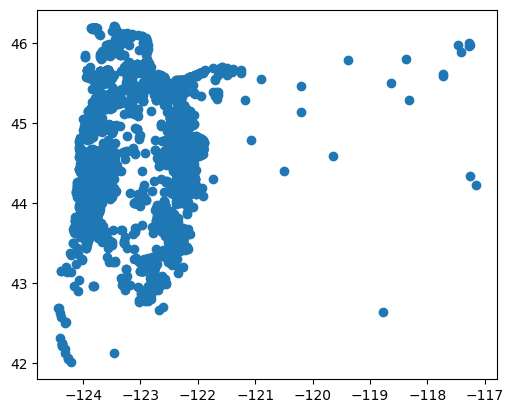

In [4]:
known_time.plot()

In [5]:
inState = counties.union_all(method="coverage").contains(known_time.geometry)

In [6]:
known_time = known_time[inState]

In [7]:
known_time = known_time[["VOLUME_ft3", "geometry", "YEAR"]]

In [8]:
known_time

,VOLUME_ft3,geometry,YEAR
0,1594310.00,POINT (-123.77821 46.16399),2008.0
1,6344.53,POINT (-123.80584 46.17906),2007.0
2,21911.90,POINT (-122.65778 45.39652),2009.0
3,4731.07,POINT (-122.65831 45.39629),2009.0
4,38562.40,POINT (-122.65885 45.3976),2009.0
...,...,...,...
7227,NaN,POINT (-122.18877 43.45249),1996.0
7228,NaN,POINT (-122.42341 43.41715),1996.0
7229,NaN,POINT (-123.78996 43.81432),1996.0
7230,NaN,POINT (-123.79815 43.81184),1996.0


In [9]:
clist = []
for county in counties.iterrows():
    clist.append(county[1].geometry.contains(known_time.geometry))

In [10]:
countyCentroids = counties.to_crs(epsg=2991).centroid

In [11]:
def distMatrix(one, other):
    return np.sqrt(np.sum(np.square((one[:, None] - other[None, :])), axis=-1))

In [12]:
lon = countyCentroids.x
lat = countyCentroids.y

In [13]:
countyLocs = np.array([lon.to_numpy(), lat.to_numpy()]).T

In [14]:
countyLocs2 = (countyLocs - np.min(countyLocs, axis=0)) / (0.75 * np.max(countyLocs))

In [15]:
countyDists = distMatrix(countyLocs,  countyLocs)

In [16]:
countyDists2 = distMatrix(countyLocs2,  countyLocs2)

In [17]:
countyDists2

array([[0.        , 0.11219493, 0.13851502, ..., 1.06614876, 0.80798935,
        0.82119757],
       [0.11219493, 0.        , 0.24755389, ..., 1.13218912, 0.8028325 ,
        0.80229155],
       [0.13851502, 0.24755389, 0.        , ..., 0.96085273, 0.79164112,
        0.82148404],
       ...,
       [1.06614876, 1.13218912, 0.96085273, ..., 0.        , 0.68925206,
        0.78884114],
       [0.80798935, 0.8028325 , 0.79164112, ..., 0.68925206, 0.        ,
        0.09986441],
       [0.82119757, 0.80229155, 0.82148404, ..., 0.78884114, 0.09986441,
        0.        ]])

In [85]:
np.savetxt("county_dist_scale.dat", countyDists2)

In [18]:
countyLocs2

array([[0.10888247, 0.        ],
       [0.        , 0.02706125],
       [0.24699913, 0.01049753],
       [0.02725383, 0.18768201],
       [0.42756421, 0.06347546],
       [0.63734239, 0.08626451],
       [0.178511  , 0.2045149 ],
       [0.87085055, 0.14906485],
       [0.23253769, 0.35069337],
       [0.50005171, 0.33945522],
       [1.09118786, 0.18339417],
       [0.64149507, 0.38996292],
       [0.14692402, 0.47690622],
       [0.29075115, 0.4719956 ],
       [0.50952393, 0.50001649],
       [0.85824251, 0.47047029],
       [0.07155265, 0.51429398],
       [0.6938975 , 0.52132545],
       [0.15280931, 0.56933301],
       [1.07063005, 0.52519269],
       [0.28524989, 0.56534829],
       [0.17208066, 0.64271736],
       [0.34460078, 0.62790499],
       [0.51196489, 0.61905547],
       [0.43619732, 0.70070095],
       [0.31569838, 0.70929458],
       [0.58811621, 0.67384033],
       [0.20775853, 0.71516819],
       [0.10255071, 0.69558679],
       [0.6639997 , 0.66776778],
       [1.

In [87]:
np.savetxt("counties_coords.dat", countyLocs2)

In [19]:
np.max(countyDists2)

np.float64(1.3378530437512681)

In [20]:
countyDists

array([[     0.        ,  55455.90183799,  68465.44044762, ...,
        526977.82146878, 399374.34736775, 405902.93259825],
       [ 55455.90183799,      0.        , 122361.35723614, ...,
        559620.3640945 , 396825.41469566, 396558.02918439],
       [ 68465.44044762, 122361.35723614,      0.        , ...,
        474931.92306285, 391293.72062497, 406044.52580738],
       ...,
       [526977.82146878, 559620.3640945 , 474931.92306285, ...,
             0.        , 340684.68150577, 389909.73995322],
       [399374.34736775, 396825.41469566, 391293.72062497, ...,
        340684.68150577,      0.        ,  49361.15068114],
       [405902.93259825, 396558.02918439, 406044.52580738, ...,
        389909.73995322,  49361.15068114,      0.        ]])

In [21]:
countyDesign = np.hstack([x.to_numpy()[:, None] for x in clist]) * 1.0

In [22]:
countyDesign.shape

(7222, 36)

In [23]:
times = pd.get_dummies(known_time["YEAR"]).columns.to_numpy()

In [20]:
year_design = pd.get_dummies(known_time["YEAR"], "y_").to_numpy() * 1.0

In [21]:
time_design = year_design

In [24]:
time_dist = distMatrix(times[:, None], times[:, None])

In [28]:
pd.Series(times).to_csv("Years.csv")

In [23]:
time_dist

array([[ 0.,  4.,  5., ..., 93., 94., 95.],
       [ 4.,  0.,  1., ..., 89., 90., 91.],
       [ 5.,  1.,  0., ..., 88., 89., 90.],
       ...,
       [93., 89., 88., ...,  0.,  1.,  2.],
       [94., 90., 89., ...,  1.,  0.,  1.],
       [95., 91., 90., ...,  2.,  1.,  0.]])

In [24]:
known_time

,VOLUME_ft3,geometry,YEAR
0,1594310.00,POINT (-123.77821 46.16399),2008.0
1,6344.53,POINT (-123.80584 46.17906),2007.0
2,21911.90,POINT (-122.65778 45.39652),2009.0
3,4731.07,POINT (-122.65831 45.39629),2009.0
4,38562.40,POINT (-122.65885 45.3976),2009.0
...,...,...,...
7227,NaN,POINT (-122.18877 43.45249),1996.0
7228,NaN,POINT (-122.42341 43.41715),1996.0
7229,NaN,POINT (-123.78996 43.81432),1996.0
7230,NaN,POINT (-123.79815 43.81184),1996.0


In [25]:
elev

,elev,elev_std,geometry
0,0,0,POINT (-124.025 46.29167)
1,0,0,POINT (-124.03333 46.28333)
2,0,0,POINT (-124.025 46.28333)
3,0,0,POINT (-124.01667 46.28333)
4,3,2,POINT (-124.025 46.275)
...,...,...,...
411353,1628,6,POINT (-117.075 42)
411354,1634,6,POINT (-117.06667 42)
411355,1638,6,POINT (-117.05833 42)
411356,1638,5,POINT (-117.05 42)


In [26]:
known_time_elev = known_time.to_crs("+proj=cea").sjoin_nearest(elev.to_crs("+proj=cea"), "left").to_crs(known_time.crs)

In [27]:
slides = known_time_elev[["VOLUME_ft3", "YEAR", "elev", "elev_std"]]

In [28]:
countyElevStds = []
for county in counties.iterrows():
    county = county[1].geometry
    correspElevs = elev[county.contains(elev.geometry)]
    countyElevStds.append(np.sqrt(np.mean(np.square(correspElevs["elev_std"].to_numpy()))))

In [29]:
counties["county_elev_std"] = np.array(countyElevStds)

In [309]:
np.savetxt("time_design.dat", time_design, fmt="%.1f")
np.savetxt("time_dist.dat", time_dist, fmt="%.1f")
np.savetxt("counties_design.dat", countyDesign, fmt="%.1f")
np.savetxt("counties_dist.dat", countyDists)
counties[["COUNTY_NAME", "COBCODE", "county_elev_std"]].to_csv("counties.csv", index = False)
slides.to_csv("slides.csv", index = False)

In [30]:
rSlides = slides.reset_index(drop=True)
y = np.zeros((countyDesign.shape[1], year_design.shape[1])).astype("int64")
for cidx in range(countyDesign.shape[1]):
    countySlides = rSlides[countyDesign[:, cidx].astype("bool")]
    actualYears = np.argwhere(year_design)[:, 1][countySlides.index.to_numpy()]
    for yidx in actualYears:
        y[cidx, yidx] += 1

In [310]:
np.savetxt("landslides_county_year.dat", y, fmt="%.1f")

In [31]:
known_time

,VOLUME_ft3,geometry,YEAR
0,1594310.00,POINT (-123.77821 46.16399),2008.0
1,6344.53,POINT (-123.80584 46.17906),2007.0
2,21911.90,POINT (-122.65778 45.39652),2009.0
3,4731.07,POINT (-122.65831 45.39629),2009.0
4,38562.40,POINT (-122.65885 45.3976),2009.0
...,...,...,...
7227,NaN,POINT (-122.18877 43.45249),1996.0
7228,NaN,POINT (-122.42341 43.41715),1996.0
7229,NaN,POINT (-123.78996 43.81432),1996.0
7230,NaN,POINT (-123.79815 43.81184),1996.0


In [33]:
lon

0    -1.375413e+07
1    -1.382762e+07
2    -1.366210e+07
3    -1.381407e+07
4    -1.354198e+07
5    -1.340128e+07
6    -1.371222e+07
7    -1.324337e+07
8    -1.367844e+07
9    -1.349498e+07
10   -1.309374e+07
11   -1.339798e+07
12   -1.374009e+07
13   -1.364053e+07
14   -1.348930e+07
15   -1.324785e+07
16   -1.379328e+07
17   -1.336139e+07
18   -1.373830e+07
19   -1.309962e+07
20   -1.364603e+07
21   -1.372662e+07
22   -1.360555e+07
23   -1.348832e+07
24   -1.354213e+07
25   -1.362712e+07
26   -1.343509e+07
27   -1.370326e+07
28   -1.377677e+07
29   -1.338179e+07
30   -1.313669e+07
31   -1.331203e+07
32   -1.304448e+07
33   -1.321775e+07
34   -1.370211e+07
35   -1.377205e+07
dtype: float64